<a href="https://colab.research.google.com/github/meovvmiao/AIPI-590-XAI/blob/main/hw2/aipi590_hw2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AIPI 590 - XAI | Assignment #00
### Description
### Eleanor Jiang

#### Include the button below. Change the link to the location in your github repository:


[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/meovvmiao/AIPI-590-XAI/blob/main/aipi590_hw2.ipynb)

In [1]:
# Please use this to connect your GitHub repository to your Google Colab notebook
# Connects to any needed files from GitHub and Google Drive
import os

# Remove Colab default sample_data
!rm -r ./sample_data

# Clone GitHub files to colab workspace
repo_name = "AIPI-590-XAI" # Change to your repo name
git_path = 'https://github.com/meovvmiao/AIPI-590-XAI.git' #Change to your path
!git clone "{git_path}"

# Install dependencies from requirements.txt file
#!pip install -r "{os.path.join(repo_name,'requirements.txt')}" #Add if using requirements.txt

# Change working directory to location of notebook
notebook_dir = 'hw2'
# path_to_notebook = os.path.join(repo_name,notebook_dir)
path_to_notebook = os.path.join(repo_name, notebook_dir)
%cd "{path_to_notebook}"
%ls

rm: cannot remove './sample_data': No such file or directory
fatal: destination path 'AIPI-590-XAI' already exists and is not an empty directory.
/content/AIPI-590-XAI/hw2
aipi590_hw2.ipynb  __pycache__/  utils.py


# Exploratory Analysis

In [74]:
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.linear_model import LinearRegression, LogisticRegression
from scipy import stats
from sklearn.metrics import r2_score, confusion_matrix, classification_report, accuracy_score, roc_auc_score
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson
import statsmodels.api as sm
from pygam import LogisticGAM, s, f
from sklearn.inspection import PartialDependenceDisplay

from utils import ModelAssumptionChecker

In [4]:
# Download the dataset from Kaggle
path = kagglehub.dataset_download("blastchar/telco-customer-churn")
df = pd.read_csv('/kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv')
df.head()

Using Colab cache for faster access to the 'telco-customer-churn' dataset.


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [14]:
# What are the columns
df.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [14]:
# feature_columns = df.columns.tolist()[1:-1]
# target = df.Churn
# Make dummy variable to 0 and 1
feature_columns = df.columns.tolist()[1:-1]
numeric_columns = df[feature_columns].select_dtypes(include=np.number).columns.tolist()
text_columns = df[feature_columns].select_dtypes(include=['object', 'category']).columns.tolist()

In [17]:
df[numeric_columns].head() # senior citizen is dummy

,SeniorCitizen,tenure,MonthlyCharges
0,0,1,29.85
1,0,34,56.95
2,0,2,53.85
3,0,45,42.30
4,0,2,70.70


In [16]:
df[text_columns].head() # total charges is numeric

,gender,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,TotalCharges
0,Female,Yes,No,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85
1,Male,No,No,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,1889.5
2,Male,No,No,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,108.15
3,Male,No,No,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),1840.75
4,Female,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,151.65


In [20]:
numeric_columns = numeric_columns[1:]+['TotalCharges']
text_columns = text_columns[:-1]+['SeniorCitizen']

In [23]:
df['MultipleLines'].unique() # should only have 2 categories

array(['No phone service', 'No', 'Yes'], dtype=object)

In [24]:
# code 'No phone service' to No
df['MultipleLines'] = df['MultipleLines'].replace('No phone service', 'No')
# code every other dummy categories to numbers
for col in text_columns:
  categories = df[col].unique()
  df[col] = df[col].replace(categories, range(len(categories)))

/tmp/ipython-input-2530439827.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace(categories, range(len(categories)))


In [27]:
df['TotalCharges'] = df['TotalCharges'].replace(' ', np.nan)

In [28]:
# code TotalCharges to the correct datatype
df['TotalCharges'] = df['TotalCharges'].astype(float)

In [29]:
# perform simple NA fills
# if text, fill with mode
# if numeric, fill with median
for col in df.columns[1:-1]:
  if col in text_columns:
    df[col] = df[col].fillna(df[col].mode()[0])
  else:
    df[col] = df[col].fillna(df[col].median())

In [30]:
# encode target variable
df['Churn'] = df['Churn'].replace({'No': 0, 'Yes': 1})

/tmp/ipython-input-2902993517.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Churn'] = df['Churn'].replace({'No': 0, 'Yes': 1})


In [32]:
df.describe()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.504756,0.162147,0.516967,0.299588,32.371149,0.903166,0.421837,0.872923,0.720006,0.871788,0.777226,0.723555,0.817691,0.821241,0.690473,0.407781,1.315633,64.761692,2281.916928,0.265370
std,0.500013,0.368612,0.499748,0.458110,24.559481,0.295752,0.493888,0.737796,0.796885,0.738369,0.778826,0.795896,0.763212,0.761725,0.833755,0.491457,1.148907,30.090047,2265.270398,0.441561
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.250000,18.800000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,9.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,35.500000,402.225000,0.000000
50%,1.000000,0.000000,1.000000,0.000000,29.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,70.350000,1397.475000,0.000000
75%,1.000000,0.000000,1.000000,1.000000,55.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,89.850000,3786.600000,1.000000
max,1.000000,1.000000,1.000000,1.000000,72.000000,1.000000,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,3.000000,118.750000,8684.800000,1.000000


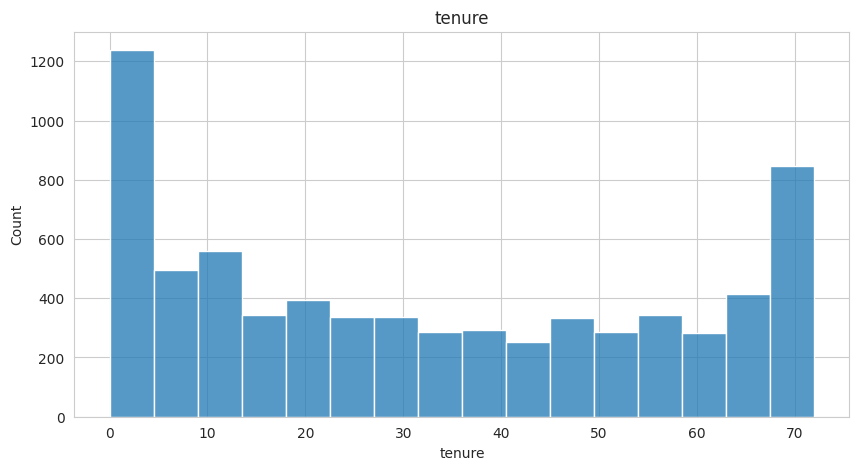

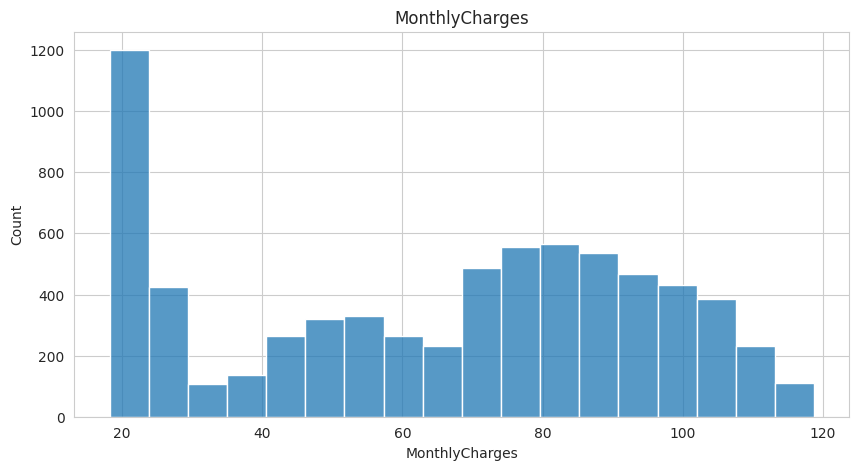

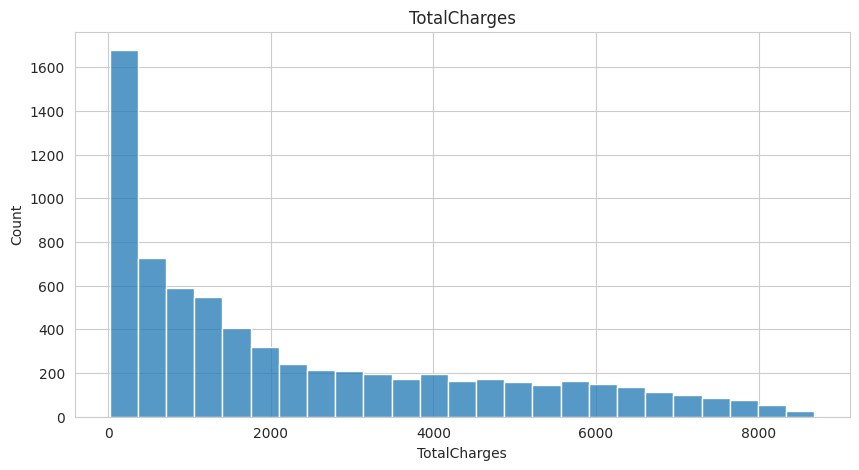

In [44]:
for col in numeric_columns:
  fig, ax = plt.subplots(figsize=(10, 5))
  sns.histplot(df[col], ax=ax)
  ax.set_title(col)

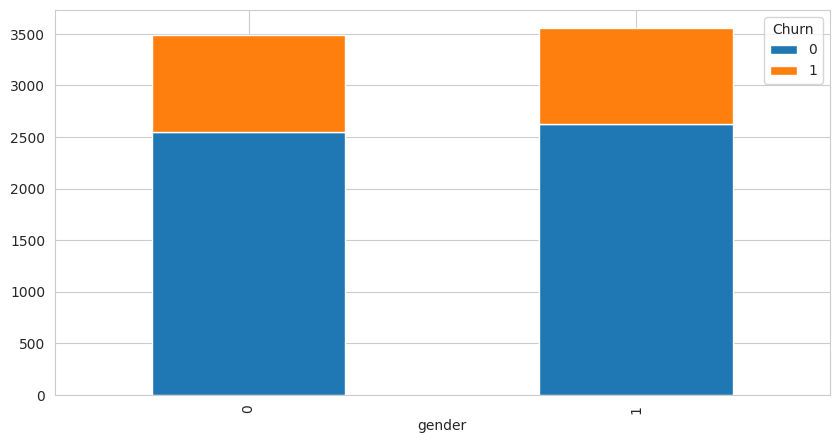

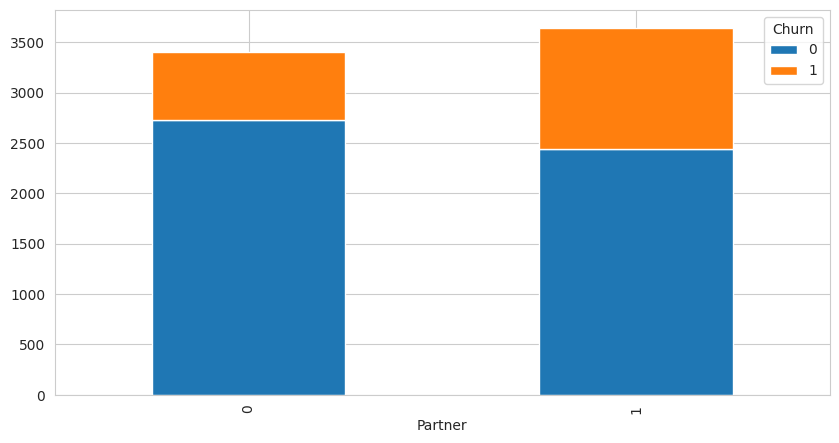

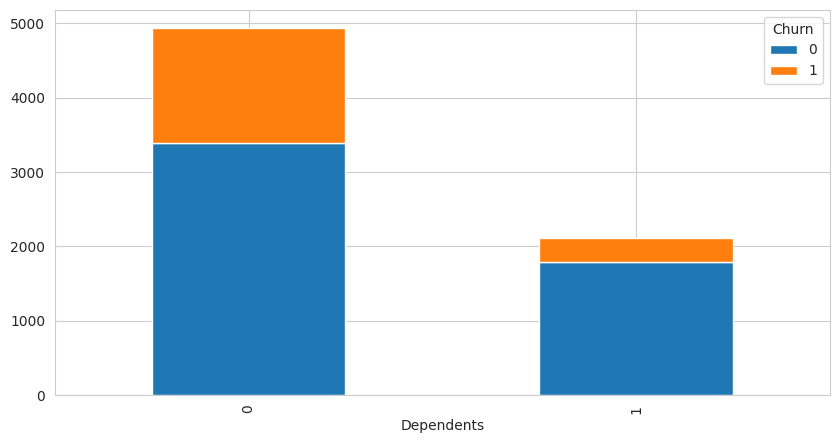

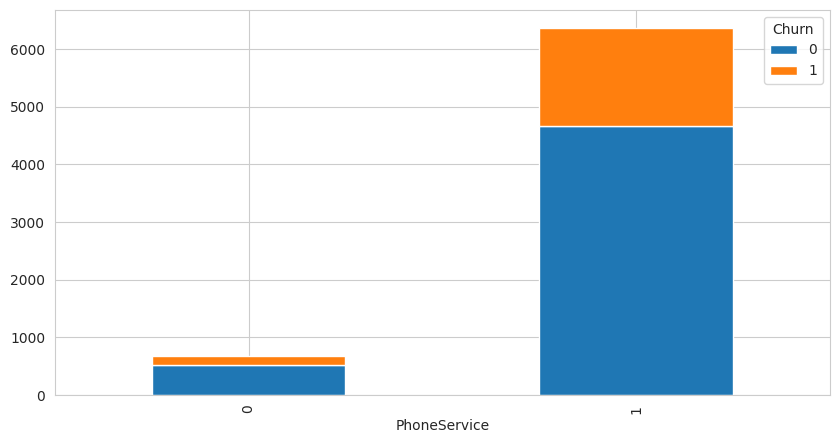

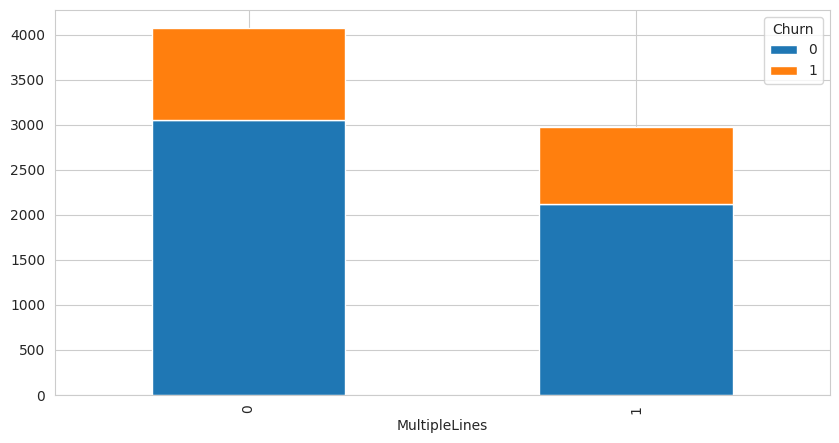

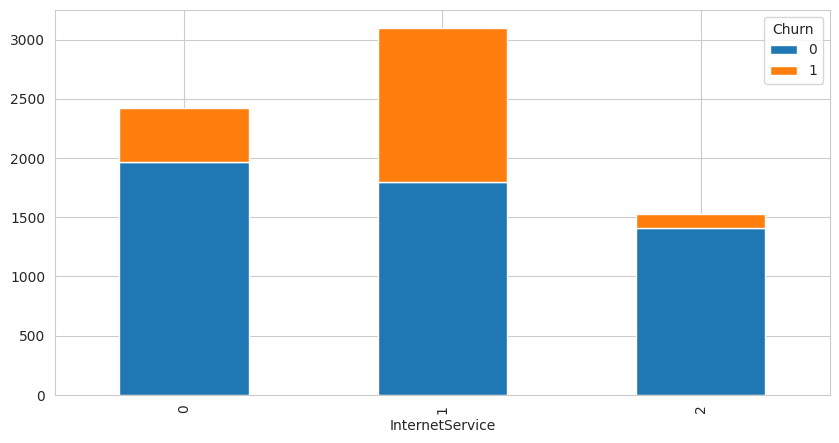

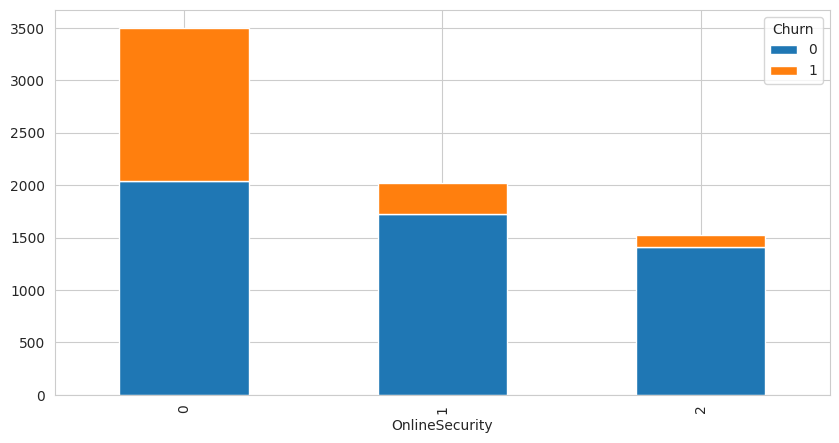

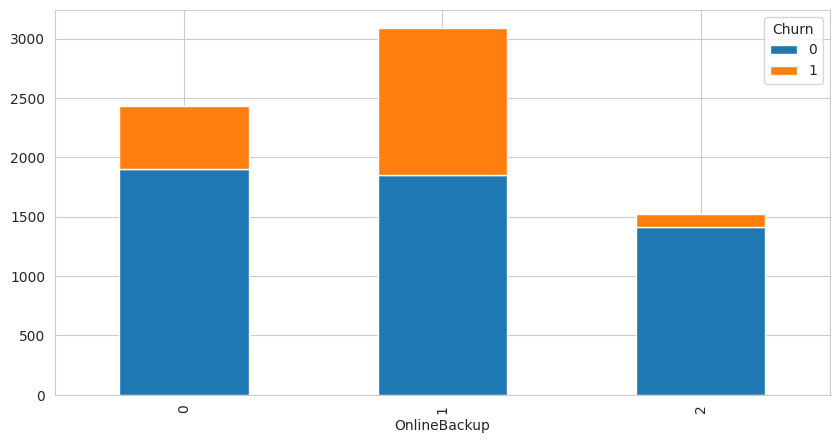

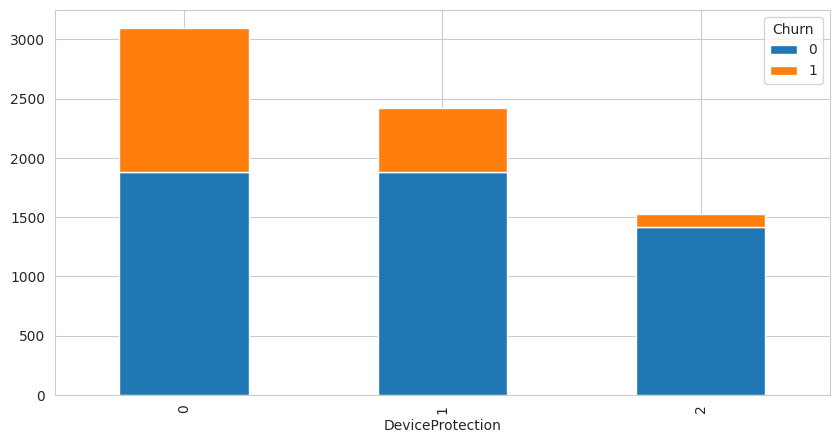

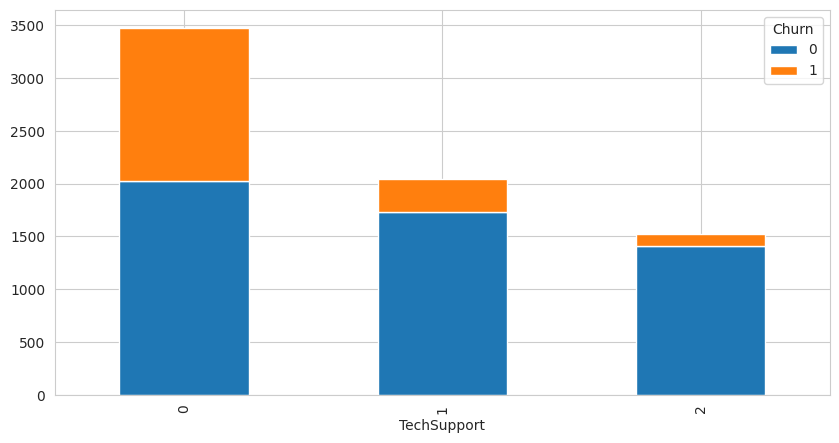

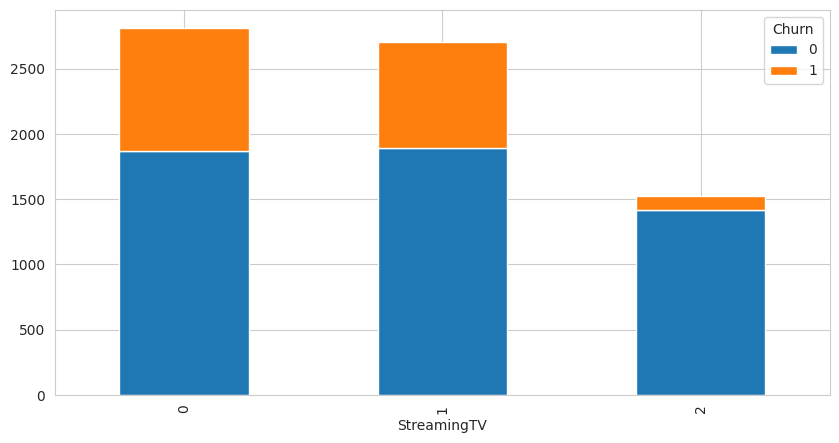

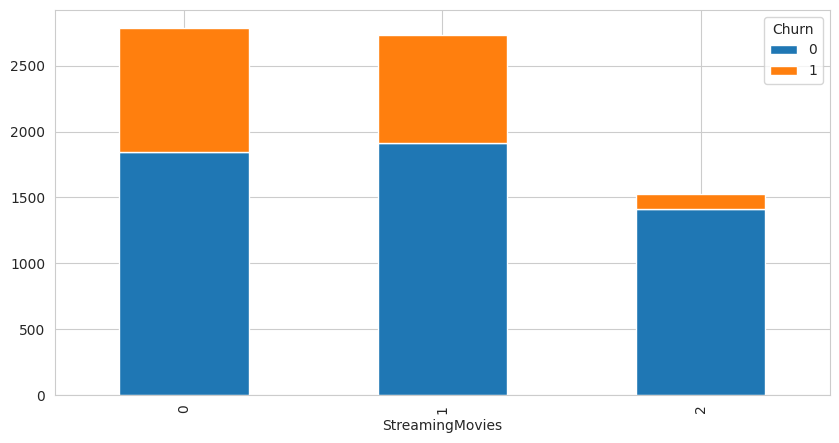

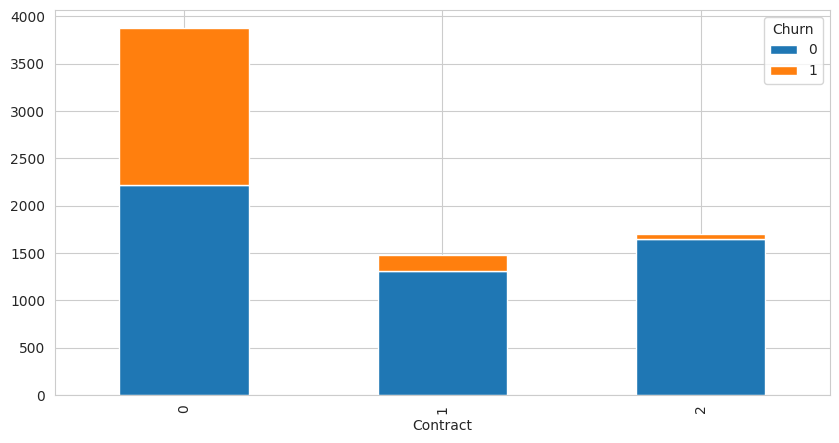

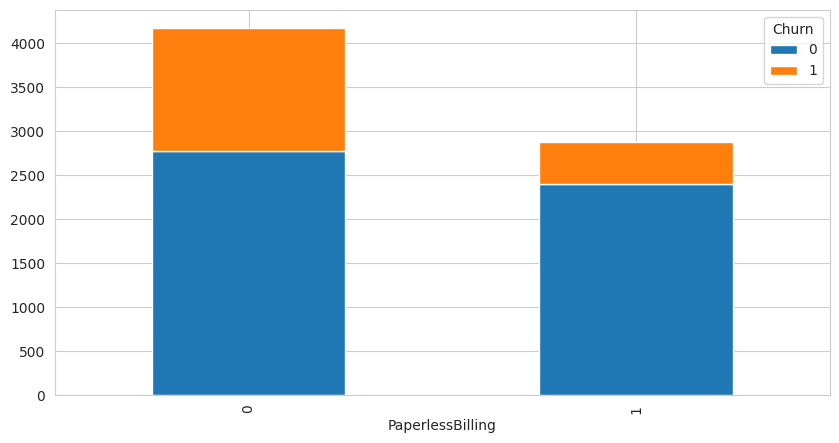

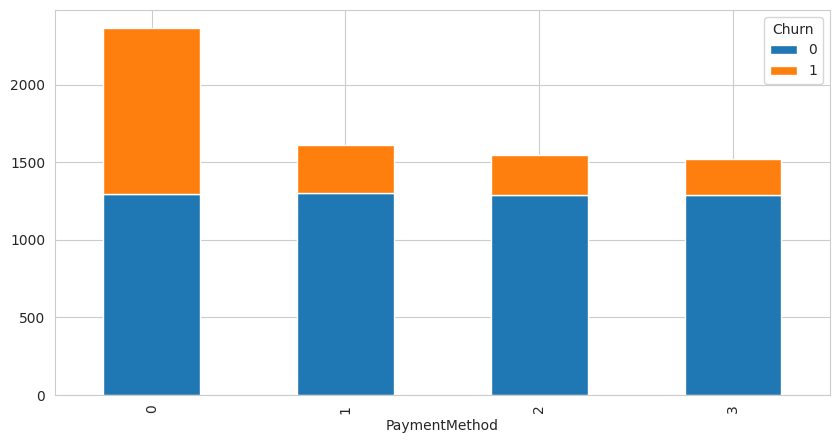

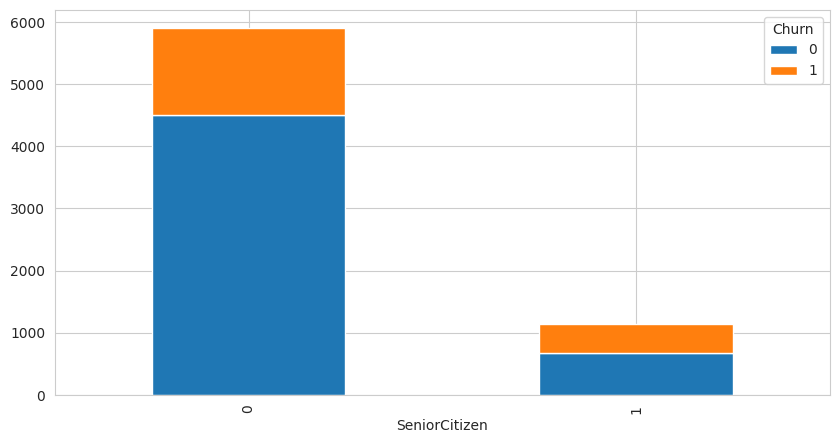

In [46]:
# plot categorical
for col in text_columns:
  fig, ax = plt.subplots(figsize=(10, 5))
  cross_tab = pd.crosstab(df[col], df['Churn'])
  cross_tab.plot(kind='bar', stacked=True, ax=ax)

<Axes: >

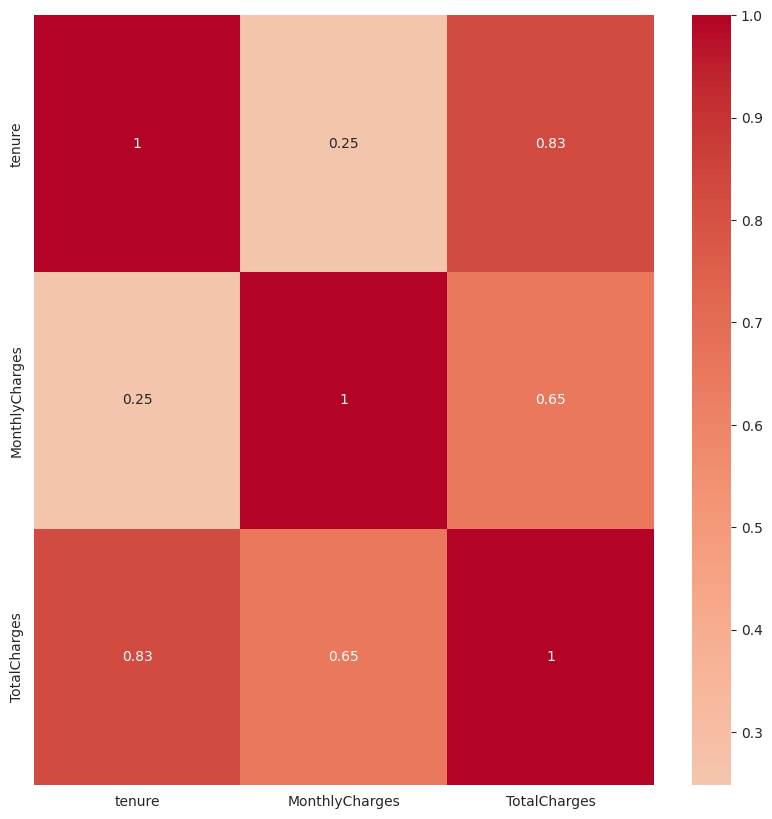

In [47]:
# corr plot
fig, ax = plt.subplots(figsize=(10, 10))
corr_matrix = df[numeric_columns].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, ax=ax)

In [48]:
# it seems that total charge can be calculateed by tenure and monthly charges
# exclude this feature
numeric_columns.remove('TotalCharges')
numeric_columns

['tenure', 'MonthlyCharges']

# Model Building

## Linear Regression

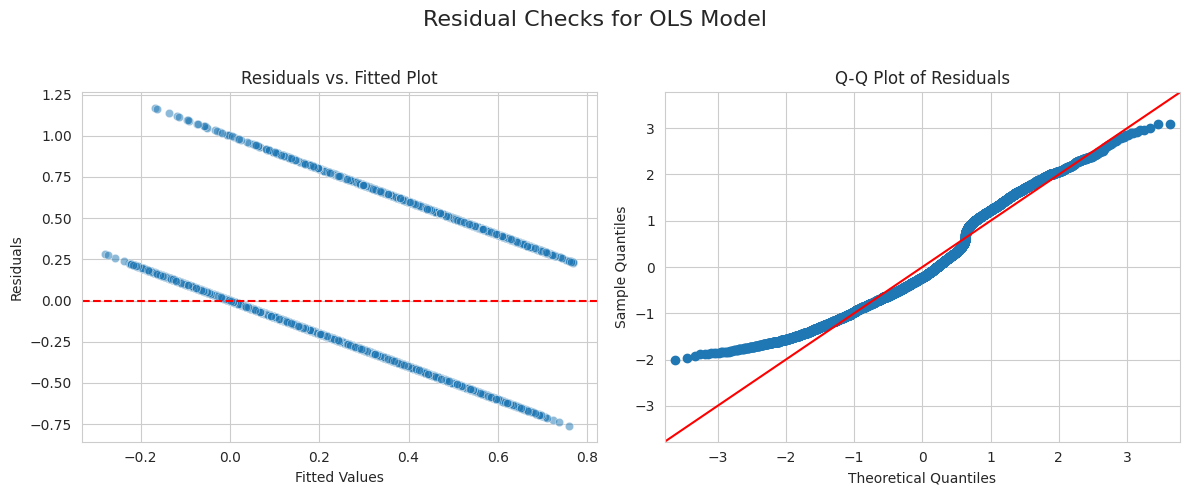

In [56]:
X = df[numeric_columns+text_columns]
y = df['Churn']

X_const = sm.add_constant(X)
ols_model = sm.OLS(y, X_const).fit()
residuals = ols_model.resid
fitted = ols_model.fittedvalues

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Residuals vs. Fitted (Homoscedasticity)
sns.scatterplot(x=fitted, y=residuals, ax=ax1, alpha=0.5)
ax1.axhline(0, color='red', linestyle='--')
ax1.set_title("Residuals vs. Fitted Plot")
ax1.set_xlabel("Fitted Values")
ax1.set_ylabel("Residuals")

# Q-Q Plot (Normality)
sm.qqplot(residuals, line='45', fit=True, ax=ax2)
ax2.set_title("Q-Q Plot of Residuals")
plt.suptitle("Residual Checks for OLS Model", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

The residuals and QQ plot do not support the assumptions of linear models and therefore homoscedasticity and normality are violated. Though we did not pull out performance metrics, the accuracy should be low.

In [57]:
# access performance
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Churn   R-squared:                       0.272
Model:                            OLS   Adj. R-squared:                  0.270
Method:                 Least Squares   F-statistic:                     145.9
Date:                Mon, 15 Sep 2025   Prob (F-statistic):               0.00
Time:                        01:59:38   Log-Likelihood:                -3117.3
No. Observations:                7043   AIC:                             6273.
Df Residuals:                    7024   BIC:                             6403.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.4349      0.028  

We can see that the r-square is 0.272. The model is not comparable to coin toss.

Holding all other variables constant, having phone service is associated with a decrease of 0.1036 in the predicted probability of churn. Since the target variable 'Churn' is coded as 1 for customers who churned and 0 for those who did not, a negative coefficient indicates a lower likelihood of churn.

However, as noted earlier, the linear model's assumptions are not well-supported by the data. The logistic regression model is generally more appropriate for binary classification tasks like predicting churn.

## Logistic Model

/tmp/ipython-input-856966791.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  logit_df = df_binned.groupby(f'{col}_bin')['Churn'].agg(['mean', 'count']).reset_index()
/tmp/ipython-input-856966791.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  logit_df = df_binned.groupby(f'{col}_bin')['Churn'].agg(['mean', 'count']).reset_index()


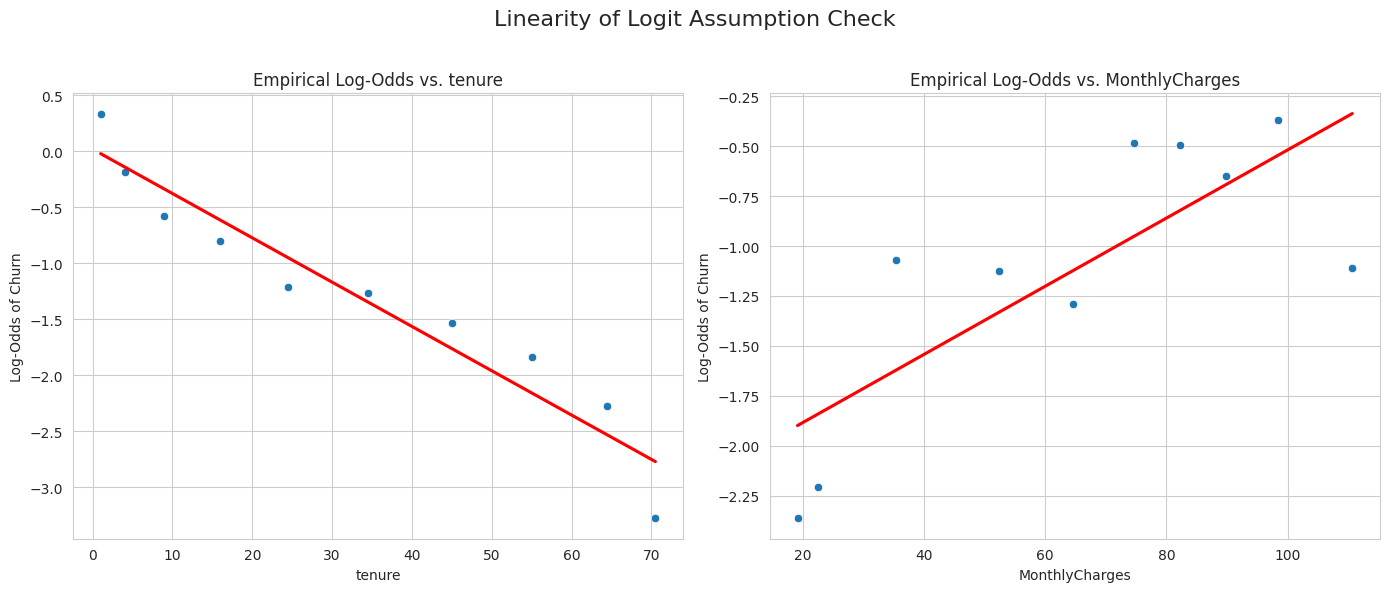

In [58]:
# check linearity
plt.figure(figsize=(14, 6))
for i, col in enumerate(numeric_columns):
    # Bin the feature to calculate empirical log-odds
    df_binned = df.copy()
    df_binned[f'{col}_bin'] = pd.qcut(df_binned[col], q=10, duplicates='drop')

    # Calculate mean churn rate per bin
    logit_df = df_binned.groupby(f'{col}_bin')['Churn'].agg(['mean', 'count']).reset_index()

    # Calculate log-odds (add a small epsilon to avoid log(0))
    logit_df['log_odds'] = np.log((logit_df['mean'] + 0.001) / (1 - logit_df['mean'] + 0.001))

    # Get the midpoint of the bin for plotting
    logit_df[f'{col}_mid'] = logit_df[f'{col}_bin'].apply(lambda x: x.mid)

    # Plot
    plt.subplot(1, 2, i + 1)
    sns.scatterplot(data=logit_df, x=f'{col}_mid', y='log_odds')
    sns.regplot(data=logit_df, x=f'{col}_mid', y='log_odds', scatter=False, color='red', ci=None)
    plt.title(f'Empirical Log-Odds vs. {col}')
    plt.xlabel(col)
    plt.ylabel('Log-Odds of Churn')

plt.suptitle("Linearity of Logit Assumption Check", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


1. The lod-odds seem not so linear.
2. However, we have solved multi-collinearity by excluding TotalCharges.
3. From the descriptive stats table, we could observe that there are no significant outliers in the dataset.
4. There is as well no perfect separation.
5. There are 7043 observations so large sample size is also satisfied.

In [64]:
# Build logistic model and access its performance
lgr = LogisticRegression()
lgr.fit(X, y)
y_pred = lgr.predict(X)
print("\nClassification Report:\n", classification_report(y, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.90      0.87      5174
           1       0.66      0.55      0.60      1869

    accuracy                           0.80      7043
   macro avg       0.75      0.72      0.73      7043
weighted avg       0.80      0.80      0.80      7043



/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [67]:
lgr.coef_

array([[-0.03358901,  0.01672618, -0.02118659, -0.00175101, -0.14986785,
        -0.79010483,  0.19933743,  0.47458265, -0.50196441,  0.2061178 ,
        -0.09338633, -0.46197431,  0.11855924,  0.13878763, -0.66822148,
        -0.32150703, -0.13445317,  0.20638404]])

From the classification report, we can see that the logistic model performs better than the linear model with an accuracy of 0.80. The recall and precision for 'Yes' in `Churn` is lower because its support is imbalanced.

For a one-unit increase in the 'PhoneService', the log-odds of churn decrease by 0.79, holding all other variables constant. In other words, having phone service is associated with a lower likelihood of churning.

In [70]:
X.columns

Index(['tenure', 'MonthlyCharges', 'gender', 'Partner', 'Dependents',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'SeniorCitizen'],
      dtype='object')

## GAM

In [73]:
gam_terms = s(0) + s(1) + f(2) + f(3) + f(4) + f(5) + f(6) + f(7) + f(8) + f(9) + f(10) + f(11) + f(12) + f(13) + f(14) + f(15) + f(16) + f(17)
gam = LogisticGAM(gam_terms).fit(X, y)

y_pred_gam = gam.predict(X)
y_pred_proba_gam = gam.predict_proba(X)


accuracy_gam = accuracy_score(y, y_pred_gam)
auc_gam = roc_auc_score(y, y_pred_proba_gam)
print(f"Accuracy: {accuracy_gam:.4f}")
print(f"AUC-ROC: {auc_gam:.4f}\n")
print("Classification Report:")
print(classification_report(y, y_pred_gam))

Accuracy: 0.8092
AUC-ROC: 0.8557

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.91      0.87      5174
           1       0.67      0.54      0.60      1869

    accuracy                           0.81      7043
   macro avg       0.76      0.72      0.74      7043
weighted avg       0.80      0.81      0.80      7043



The GAM result is fair. By closer look, we could see it has slight improvement of precision and recall of the 'Yes' in `Churn`, from 0.66 to 0.67, while other metrics remain the same.

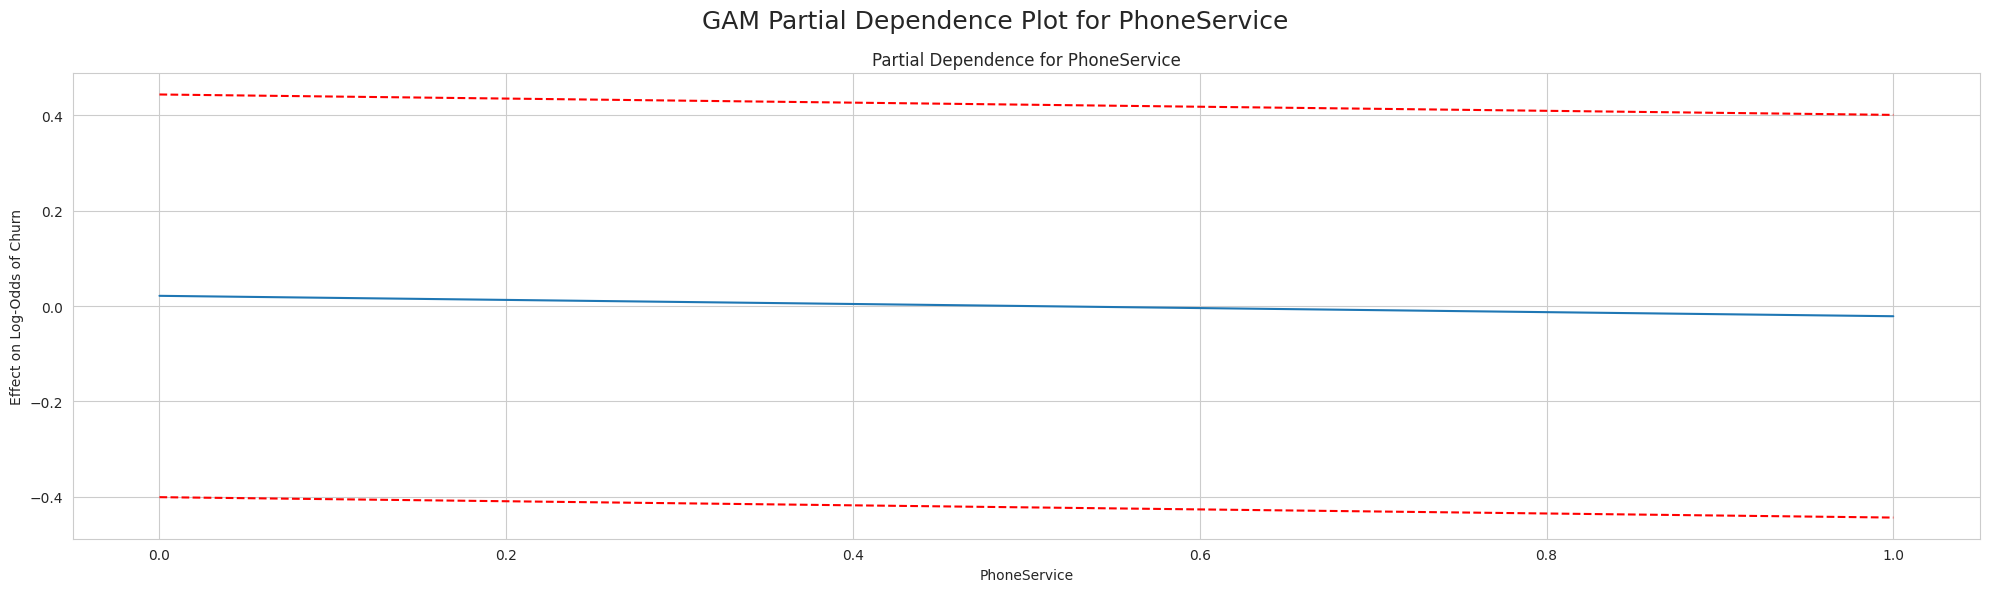

In [79]:
fig, ax = plt.subplots(figsize=(20, 6))
pdp, confi = gam.partial_dependence(term=5, X=X, width=0.95)

# Correctly access the column for plotting
ax.plot(X.iloc[:, 5], pdp)
ax.plot(X.iloc[:, 5], confi, c='r', ls='--')

ax.set_title(f'Partial Dependence for {X.columns[5]}')
ax.set_xlabel(X.columns[5])
ax.set_ylabel('Effect on Log-Odds of Churn')
ax.grid(True)

plt.suptitle('GAM Partial Dependence Plot for PhoneService', fontsize=18)
plt.tight_layout()
plt.show()

The GAM learned a simple linear relationship for `PhoneService`. As a customer subscribes phone services, their log-odds of churning decrease steadily and predictably.

# Model Comparison

Overall, the linear model performs very bad on this dataset given the assumptions are not satisfied in addition to the binary feature of our target variable. The nature of our target variable favors logistic model and the GAM. Both models perform relatively well without much calibration on the data (transformation, scaling, feature selection, etc.).

In general, linear model and logistic model are built upon solid formulas and well-formed stats theories, and is very clear and easy to interpret. The predictions are transparant. However, linear model perform less well in binary features than logistic model.

I would recommend the company to choose logistic model because GAM only gives slightly better metrics while sacraficing interpretability compared to logistic model.